### **Notebook to make predictions with reprocessed Yoneda and Henson data and EFLUX2 and SPOT** 

##### **Import python packages**

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import cobra
#import cplex
%matplotlib inline
from matplotlib import pyplot as plt
from edd_utils import login, export_study, export_metadata

##### **Load data**

In [2]:
# Study to Download
study_slug = 'biodesign_yoneda_set3_reprocessed'
# EDD server
edd_server = 'public-edd.jbei.org'
user       = 'schenkch'

In [3]:
session = login(edd_server=edd_server, user=user)

df = export_study(session, study_slug, edd_server=edd_server)
#df.head()

Password for schenkch:  ···············


##### **Filter transcriptomics data from all EDD data into different dataframes**

In [4]:
df_Trans = df[df['Protocol'].str.contains('Transcriptomics')]
df_Trans.head()
df_Trans.loc[0,'Line Description']

'R. Opacus adaptively evolved strain1 with 1.0 g/l glucose as carbon source and 0.05 g/l ammonium sulfate as nitrogen source'

##### **Load Genome Scale Model**

In [5]:
file_name =  '../GSMs/Ropacus_annotated_curated_with_phenol_custom_biomass.xml'
model = cobra.io.read_sbml_model(file_name)

##### **Import EFLUX2 and SPOT Code**

In [6]:
OptlangDir = '../EFLUX2_SPOT'
sys.path.append(OptlangDir)
from ensemblemethods import EFlux2,SPOT

##### **Transform data to dataframe with just index as gene identifiers and one column for values**
##### !!!!TODO: Generalize for multiple time points


In [7]:
#Function to construct df from EFLUX2 and SPOT functions: Needs to be modified for multiple time points!!!!!
def constructTransdffrompred(transdata, linename, conditionstring):
    transdataPhe = transdata[transdata['Line Description'].str.contains(conditionstring)]
    transdataWTPR1 = transdataPhe[transdataPhe['Line Name']==linename]
    transdataWTPR1new = transdataWTPR1.filter(['Value', 'Measurement Type'])#pd.DataFrame(data=df_TransWTPR1.loc[:,'Value'], index=df_TransWTPR1['Measurement Type'])
    transdataWTPR1new2 = transdataWTPR1new.set_index('Measurement Type')
    return transdataWTPR1new2

#### **EFLUX2 Predictions**

In [8]:
#Function for EFLUX2 and SPOT Predictions:
def eflux2pred(model, transcriptdf, linename, substrate, sub_uptake_rate, conditionstring):    
    with model:
        medium = model.medium
        if substrate=='phenol':
            model.objective = 'Growth_Phenol'
            model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
            model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
            medium = {key:1000 for (key,value) in model.medium.items()}
            medium["EX_glc__D_e"] = 0.0
            #medium["EX_phenol_e"] = sub_uptake_rate
        elif substrate=='glucose':
            model.objective = 'Growth_Glucose'
            model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
            model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
            medium = {key:1000 for (key,value) in model.medium.items()}
            #medium["EX_glc__D_e"] = sub_uptake_rate
            medium["EX_phenol_e"] = 0.0
        else:
            print('Unknown substrate: Please choose among phenol and glucose')
        model.medium = medium
        eflux2sol = EFlux2(model, transcriptdf)
        display(model.medium)
        #spotsol = SPOT(model, constructTransdffrompred(transcriptdf, linename, conditionstring))
    return eflux2sol#, spotsol

In [9]:
#Function for predictions for three replicates and averaging the solutions and calculating the standard deviation:
def eflux2predthreereps(model, transcriptdf, linename1, linename2, linename3, substrate, sub_uptake_rate, conditionstring):
    #call prediction functions for individual EFLUX2 predictions for all 3 replicates:
    transdata_R1 = constructTransdffrompred(transcriptdf, linename1, conditionstring)
    transdata_R2 = constructTransdffrompred(transcriptdf, linename2, conditionstring)
    transdata_R3 = constructTransdffrompred(transcriptdf, linename3, conditionstring)
 
    eflux2sol_R1 = eflux2pred(model, transdata_R1, linename1, substrate, sub_uptake_rate, conditionstring)
    eflux2sol_R2 = eflux2pred(model, transdata_R2, linename2, substrate, sub_uptake_rate, conditionstring)
    eflux2sol_R3 = eflux2pred(model, transdata_R3, linename3, substrate, sub_uptake_rate, conditionstring)
    
    #EFLUX2 calculations:
    eflux2sol_R1_df = pd.DataFrame(eflux2sol_R1.fluxes, columns=['fluxes'])
    eflux2sol_R2_df = pd.DataFrame(eflux2sol_R2.fluxes, columns=['fluxes'])
    eflux2sol_R3_df = pd.DataFrame(eflux2sol_R3.fluxes, columns=['fluxes'])
    eflux2sol_all = pd.concat([eflux2sol_R1_df, eflux2sol_R2_df, eflux2sol_R3_df], axis=1)

    eflux2sol = pd.DataFrame(eflux2sol_all.mean(axis=1), columns=['fluxes'])
    eflux2sol_std = eflux2sol_all.std(axis=1)
    
    return eflux2sol, eflux2sol_std

In [10]:
eflux2sol, eflux2sol_std = eflux2predthreereps(model, df_Trans, 'WT-LN-G-R1', 'WT-LN-G-R2','WT-LN-G-R3', 'glucose', 100, '1.0 g/l glucose as carbon source')

FBA status optimal
FBA solution 0.6189480042770429


EFlux2 status optimal
EFlux2 solution 6061.032453055146


{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

FBA status optimal
FBA solution 0.2103749195934234


EFlux2 status optimal
EFlux2 solution 501.0415458534275


{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

FBA status optimal
FBA solution 0.5044710616634364


EFlux2 status optimal
EFlux2 solution 4746.0580235263205


{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

##### **Save solution to data frame**

In [11]:
eflux2soldf = pd.DataFrame(eflux2sol, columns=['fluxes'])
eflux2solstddf = pd.DataFrame(eflux2sol_std, columns=['stds'])

In [12]:
# eflux2soldf

##### **Check External Metabolites solution**

In [13]:
exchange_list = []
for ind in eflux2soldf.index:
    if 'EX_' in str(ind):
        exchange_list.append(ind)
#exchange_list

In [14]:
eflux2soldf.loc[exchange_list,:]
for i in exchange_list:
    if abs(eflux2soldf.loc[i,:].values)>=0.0001:
        display(eflux2soldf.loc[i,:])
#display(eflux2soldf.loc['EX_phenol_e',:])
    

fluxes   -7.692805
Name: EX_glc__D_e, dtype: float64

fluxes    25.397693
Name: EX_h2o_e, dtype: float64

fluxes    7.151126
Name: EX_h_e, dtype: float64

fluxes    1.080847
Name: EX_ala__L_e, dtype: float64

fluxes   -0.002247
Name: EX_cl_e, dtype: float64

fluxes    2.294863
Name: EX_acald_e, dtype: float64

fluxes   -0.707934
Name: EX_pi_e, dtype: float64

fluxes   -7.813148
Name: EX_nh4_e, dtype: float64

fluxes    0.945514
Name: EX_ala__D_e, dtype: float64

fluxes   -0.00337
Name: EX_fe3_e, dtype: float64

fluxes   -0.084253
Name: EX_k_e, dtype: float64

fluxes   -0.002247
Name: EX_ca2_e, dtype: float64

fluxes   -0.003744
Name: EX_mg2_e, dtype: float64

fluxes   -0.000298
Name: EX_mn2_e, dtype: float64

fluxes   -0.000147
Name: EX_zn2_e, dtype: float64

fluxes    0.040514
Name: EX_succ_e, dtype: float64

fluxes    10.404635
Name: EX_co2_e, dtype: float64

fluxes   -0.000306
Name: EX_cu2_e, dtype: float64

fluxes   -7.485816
Name: EX_o2_e, dtype: float64

fluxes   -0.002898
Name: EX_fe2_e, dtype: float64

fluxes   -0.06728
Name: EX_so4_e, dtype: float64

fluxes    1.822086
Name: EX_val__L_e, dtype: float64

##### **Check FBA solution**

In [15]:
with model:
    medium = model.medium
    model.objective = 'Growth_Glucose'
    model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
    model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
    #sub_uptake_rate = 1.76124# just copied value to test it#growthandsubstrdata.loc[index,'substrate_consumption_rate']
    #medium["EX_glc__D_e"] = 0.0
    medium["EX_phenol_e"] = 0#sub_uptake_rate
    model.medium = medium
    # solve FBA to calculate the maximum biomass
    boundedfba_sol = model.optimize()
    print('Unbounded FBA status', boundedfba_sol.status)
    print('Unbounded FBA solution', boundedfba_sol.objective_value)

Unbounded FBA status optimal
Unbounded FBA solution 0.7933023386368265


##### **Load 13cdata**

#####  **Get 13C MFA measured fluxes for phenol**

In [16]:
glucose_fluxes = pd.read_csv('../13C_flux_data/13C_glucose_flux_data.csv')
glucose_fluxes.dropna(inplace=True)
print(f'There are {len(glucose_fluxes)} fluxes that can be compared between the MFA and FBA')
glucose_fluxes

There are 37 fluxes that can be compared between the MFA and FBA


,Pathway,Forward Reactions,Reaction,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound
0,Glucose Uptake,GLCpts,Gluc.ext + ATP -> G6P,100.00,100.00,100.00
1,Glycolysis,PGI,G6P <-> F6P,-1.61,-2.09,1.42
2,Glycolysis,F6PA and DHAK,F6P + ATP -> FBP,0.00,0.00,1.91
3,Glycolysis,F6PA and DHAK,FBP <-> DHAP + GAP,0.00,0.00,1.91
4,Glycolysis,TPI,DHAP <-> GAP,0.00,0.00,1.91
5,Glycolysis,GAPD and reverse_PGK,GAP <-> 3PG + ATP + NADH,86.56,82.61,88.84
6,Glycolysis,( reverse_PGM or PGM_1 ) and ENO,3PG <-> PEP,78.52,71.65,81.26
7,Glycolysis,FRUpts2pp or reverse_PPS or SBTpts or MNLpts o...,PEP <-> Pyr + ATP,19.02,-10.89,75.15
8,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,100.00,96.96,100.00
9,Pentose Phosphate Pathway,GND,6PG <-> Ru5P + CO2 + NADPH,6.62,2.07,10.92


#### **Plot solutions: Comparison of EFLUX2 predictions and 13c measurements**

##### **Add Glucose EFLUX2 and SPOT flux values to glucose fluxes dataframe**

In [17]:
def get_flux_value(reaction_id, solution):
    if reaction_id.startswith('reverse_'):
        reaction_id = reaction_id.split('reverse_')[1]
        return -1*solution.fluxes[reaction_id]
    else:
        return solution.fluxes[reaction_id]
def get_std_value(reaction_id, solution):
    if reaction_id.startswith('reverse_'):
        reaction_id = reaction_id.split('reverse_')[1]
        return -1*solution.stds[reaction_id]
    else:
        return solution.stds[reaction_id]

##### **Scale up solution to compare with 13C MFA measurements**

In [77]:
def scalepredictions(observed_fluxes, predictions, stdpredictions, substrate, method):
    scalepred_stds = pd.DataFrame(index=stdpredictions.index, columns= ['stds'])
    if substrate == 'phenol':
        phenoluptakerow = observed_fluxes[observed_fluxes['Pathway']=='Phenol Uptake']
        sourceuptake = float(phenoluptakerow['Flux'])
        scalepred_fluxes = predictions*(sourceuptake/(-1*predictions.loc['EX_phenol_e']))
    elif substrate == 'glucose':
        glucoseuptakerow = observed_fluxes[observed_fluxes['Pathway']=='Glucose Uptake']
        sourceuptake = float(glucoseuptakerow['Flux'])
        scalepred_fluxes = predictions.loc[:,:]*float(sourceuptake/(-1*predictions.loc['EX_glc__D_e']))
        display(float(sourceuptake/(-1*predictions.loc['EX_glc__D_e'])))
        display(predictions.loc['EX_glc__D_e']*float(sourceuptake/(-1*predictions.loc['EX_glc__D_e'])))
    else:
        print('Unknown Substrate')
    for ind in stdpredictions.index:
        if abs(stdpredictions.loc[ind,'stds'])<1e-5:
            scalepred_stds.loc[ind,'stds'] = stdpredictions.loc[ind,'stds']
        else:
            scalepred_stds.loc[ind,'stds'] = (stdpredictions.loc[ind,'stds']/predictions.loc[ind,'fluxes'])*scalepred_fluxes.loc[ind, 'fluxes']
    return scalepred_fluxes, scalepred_stds

##### **Add predictions to 13c data frame**

In [92]:
def addpredfluxes_to13cdf(observed_fluxes, predictions, stdpredictions, substrate, method):
    predicted_fluxes = []
    predicted_stds = []
    scalepred_fluxes, scalepred_stds = scalepredictions(observed_fluxes, predictions, stdpredictions, substrate, method)
    display(scalepred_fluxes.fluxes['EX_glc__D_e'])
    for _, row in observed_fluxes.iterrows():
        reactions = row['Forward Reactions']
        flux_value_pred = 0
        std_value_pred = 0
        for x in [x.strip('() ') for x in reactions.split(' or ')]:
            and_split = [y.strip('() ') for y in x.split(' and ')]
            flux_value_pred += min([get_flux_value(v, scalepred_fluxes) for v in and_split])
            std_value_pred += min([get_std_value(v,scalepred_stds) for v in and_split])
        predicted_fluxes.append(flux_value_pred)
        predicted_stds.append(std_value_pred)

    observed_fluxes[str(method) + ' Value'] = predicted_fluxes
    observed_fluxes[str(method) + ' std Value'] = predicted_stds
    
    return observed_fluxes

In [93]:
obspred_fluxes = addpredfluxes_to13cdf(glucose_fluxes, eflux2soldf, eflux2solstddf, 'glucose', 'EFLUX2')

12.9991589582858

fluxes   -100.0
Name: EX_glc__D_e, dtype: float64

-100.0

In [89]:
for r in model.metabolites.get_by_id('glc__D_p').reactions:
     print(eflux2soldf.loc[r.id], r)

fluxes    0.0
Name: GLCabcpp, dtype: float64 GLCabcpp: atp_c + glc__D_p + h2o_c --> adp_c + glc__D_c + h_c + pi_c
fluxes    2.564268
Name: GLCtex, dtype: float64 GLCtex: glc__D_e <=> glc__D_p
fluxes    2.564268
Name: GLCptspp, dtype: float64 GLCptspp: glc__D_p + pep_c --> g6p_c + pyr_c
fluxes    0.0
Name: GLCDpp, dtype: float64 GLCDpp: glc__D_p + h2o_p + q8_c --> glcn_p + h_p + q8h2_c
fluxes    0.0
Name: GLCt2pp, dtype: float64 GLCt2pp: glc__D_p + h_p --> glc__D_c + h_c
fluxes    0.0
Name: LACZpp, dtype: float64 LACZpp: h2o_p + lcts_p --> gal_p + glc__D_p


##### **Check External Metabolites solution**

##### **Check External Metabolites solution**

In [47]:
obspred_fluxes

,Pathway,Forward Reactions,Reaction,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 Value,EFLUX2 std Value
0,Glucose Uptake,GLCpts,Gluc.ext + ATP -> G6P,100.00,100.00,100.00,66.666667,4.336979e+01
1,Glycolysis,PGI,G6P <-> F6P,-1.61,-2.09,1.42,98.410410,6.432021e+01
2,Glycolysis,F6PA and DHAK,F6P + ATP -> FBP,0.00,0.00,1.91,25.686590,1.817473e+01
3,Glycolysis,F6PA and DHAK,FBP <-> DHAP + GAP,0.00,0.00,1.91,25.686590,1.817473e+01
4,Glycolysis,TPI,DHAP <-> GAP,0.00,0.00,1.91,87.076833,5.909743e+01
5,Glycolysis,GAPD and reverse_PGK,GAP <-> 3PG + ATP + NADH,86.56,82.61,88.84,176.766511,-1.193962e+02
6,Glycolysis,( reverse_PGM or PGM_1 ) and ENO,3PG <-> PEP,78.52,71.65,81.26,169.334371,-1.350031e-13
7,Glycolysis,FRUpts2pp or reverse_PPS or SBTpts or MNLpts o...,PEP <-> Pyr + ATP,19.02,-10.89,75.15,163.434935,1.126928e+02
8,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,100.00,96.96,100.00,0.000000,0.000000e+00
9,Pentose Phosphate Pathway,GND,6PG <-> Ru5P + CO2 + NADPH,6.62,2.07,10.92,0.000000,0.000000e+00


#### **Plot EFLUX2 vs 13C MFA**

##### **Plot observations vs. predictions**

In [26]:
def scatterplotcomp_obs_vs_pred(obspred_fluxes, substrate, method):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

    for pathway in list(set(obspred_fluxes['Pathway'])):
        pathway_df = obspred_fluxes[obspred_fluxes['Pathway'] == pathway]

        measured_flux_list = list(pathway_df['Flux'])
        simulated_flux_list = list(pathway_df[str(method) + ' Value'])

        ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)


    # Dashed line
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, ls="--", c=".3")
    if substrate=='phenol':
        sub = 'Phenol'
    elif substrate=='glucose':
        sub = 'Glucose'
    else:
        print("Unknown substrate")
    plt.title(r''+str(sub)+  ' 13C MFA vs. '+ str(method) + ' Fluxes', fontSize=20)
    plt.xlabel(r'13C MFA flux (per 100 mmol '+str(sub)+  ' uptake)')
    plt.ylabel(r''+ str(method) + ' flux (per 100 mmol of '+str(sub)+  ' uptake)')
    plt.legend()
    plt.show()

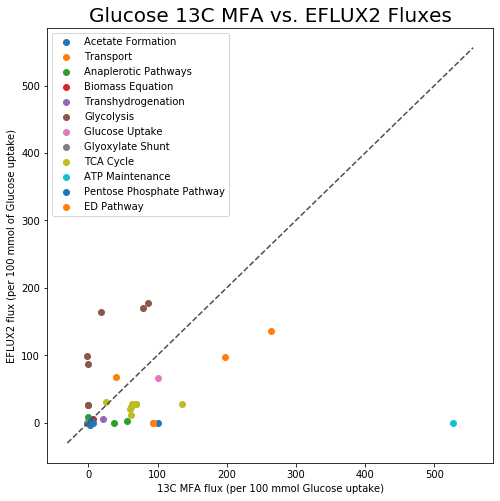

In [27]:
scatterplotcomp_obs_vs_pred(obspred_fluxes, substrate='glucose', method='EFLUX2')

##### **Plot observations vs. predictions with confidence intervals**

In [28]:
import matplotlib
import matplotlib.cm as cm
def scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes, substrate, method):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

    for pathway in list(set(obspred_fluxes['Pathway'])):
        pathway_df = obspred_fluxes[obspred_fluxes['Pathway'] == pathway]
        
        measured_flux_list = list(pathway_df['Flux'])
        simulated_flux_list = list(pathway_df[str(method) + ' Value'])
        simulated_std_list = list(pathway_df[str(method) + ' std Value'])
        measured_std_list = list(pathway_df['90% Confidence Upper Bound']-pathway_df['Flux'])
        
        
        sc = ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)
        #clb = plt.colorbar(sc)
        #if pathway!='Phenol Uptake':
        ax.errorbar(
                measured_flux_list, simulated_flux_list, xerr=[std1 for std1 in measured_std_list], yerr=[1.9*std for std in simulated_std_list],
                    #fmt="ko",
            #c=.3,
                    ecolor="gray", ls='none',
#                         elinewidth=1,
#                         capsize=2,
                alpha=0.8)
        #ax.set_xlim([min(measured_flux_list), max(measured_flux_list)*1.5])
        #ax.set_xlim([pathway_df.loc[:,'Flux'].min(), pathway_df.loc[:,'Flux'].max()])
        #x_color = clb.to_rgba(measured_flux_list)
#         norm = matplotlib.colors.Normalize(vmin=min(simulated_flux_list), vmax=max(simulated_flux_list), clip=True)
#         mapper = cm.ScalarMappable(norm=norm, cmap='viridis')
#         x_color = np.array([(mapper.to_rgba(v)) for v in simulated_flux_list])
#     for pathway,pathway2,stdpathway, color in zip(measured_flux_list, simulated_flux_list,simulated_std_list, x_color):
#         ax.errorbar(
#                 pathway, pathway2, yerr=1.96*stdpathway,
#                     fmt="ko",
#             c=.3,
#                     #ecolor="",
#                     elinewidth=1,
#                     capsize=2,
#         #capsize=2, linewidth=2.,markersize=6., mew=4., color='darkred',
#                 alpha=0.8)

    # Dashed line
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, ls="--", c=".3")
    if substrate=='phenol':
        sub = 'Phenol'
    elif substrate=='glucose':
        sub = 'Glucose'
    else:
        print("Unknown substrate")
    plt.title(r''+str(sub)+  ' 13C MFA vs. '+ str(method) + ' Fluxes', fontSize=20)
    plt.xlabel(r'13C MFA flux (per 100 mmol '+str(sub)+  ' uptake)')
    plt.ylabel(r''+ str(method) + ' flux (per 100 mmol of '+str(sub)+  ' uptake)')
    plt.legend()
    plt.show()

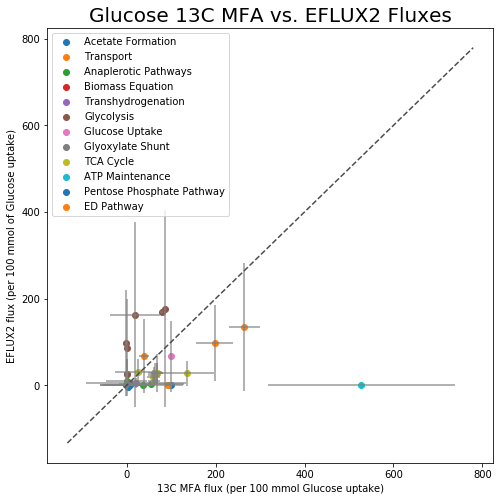

In [29]:
scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes, substrate='glucose', method='EFLUX2')

#### **SPOT Predictions**

In [ ]:
import cplex
"""
    Creates dictionary of isozymes by parsing GPR:
    Parse GPR into a dict containing isozymes (separated by 'or'). Each isozyme has a set of subunits (separated by 'and') 'and' and 'or' can occur at the same time, or can occur by itself.
    
        Parameters
        ----------
        model : cobrapy model.
        
        
        Returns
        -------
        gpr_dict: dictionary with isozymes.
        
"""
#Code only works for GPRs written in disjunctive normal form (DNF). Majority of models have them in DNF but there are some exceptions. 

def create_gprdict(model):   
    gpr_dict = dict()
    for rxn in model.reactions:
        if rxn.gene_reaction_rule:
            temp = set()
            for x in [x.strip('() ') for x in rxn.gene_reaction_rule.split(' or ')]:
                temp.add(frozenset(y.strip('() ') for y in x.split(' and ')))
            gpr_dict[rxn.id] = temp
    return gpr_dict

"""
    Calculates bound value based on transcriptomics data for reactions in gene reaction rule
    
    NOTE: 
    If a reaction R1 has the GPR of 'A and B', it would be parsed to { {A, B} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A, B) ] ) = min(A, B).
    If a reaction R1 has the GPR of 'A or B', it would be parsed to { {A}, {B} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A), min(B) ] ) = sum( [A, B] ).
    If a reaction R1 has the GPR of '(A and B) or (C and D)', it would be parsed to { {A, B}, {C, D} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A, B), min(C, D) ] ).
    
        Parameters
        ----------
        model : cobrapy model.
        Transcriptomics : pandas dataframe with transcriptomics data.Data frame has gene identifiers as index and just one column with transcript values.  
        rxn : cobrapy model reaction
        
        
        Returns
        -------
        transscript bound value: float.
"""

def findtransboundval_forgprrxns(model, Transcriptomics,rxn):
    finaltransval = 0
    for parallel_gene in create_gprdict(model)[rxn.id]:
        transvals = []
        for gene in parallel_gene:
            if gene in Transcriptomics.index:
                transvals.append(Transcriptomics.loc[gene].values)
            else:
                transvals.append(np.Inf)
            mintransval=np.min(transvals)
        finaltransval = finaltransval + mintransval
    return finaltransval

def SPOTTest(model, Transcriptomics):
    
    mets = [met.id for met in model.metabolites]
    rxns = [rxn.id for rxn in model.reactions]
    nrow = len(mets)
    ncol = len(rxns)

    rev_rxns = ['rev_'+rxn.id for rxn in model.reactions if rxn.reversibility]
    rev_ncol = len(rev_rxns)
    
    """Parse GPR into a dict containing isozymes (separated by 'or')
    # Each isozyme has a set of subunits (separated by 'and')
    #'and' and 'or' can occur at the same time, or can occur by itself."""
    #gpr_dict = create_gprdict(model)

    lb = [0.0 if rxn.reversibility else rxn.lower_bound for rxn in model.reactions] + [0.0 for rxn in model.reactions if rxn.reversibility]
    ub = [rxn.upper_bound for rxn in model.reactions] + [-rxn.lower_bound for rxn in model.reactions if rxn.reversibility]
        
    c = []
    for rxn in model.reactions:
        if rxn.gene_reaction_rule:
        #If a reaction R1 has the GPR of 'A and B', it would be parsed to { {A, B} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A, B) ] ) = min(A, B).
        #If a reaction R1 has the GPR of 'A or B', it would be parsed to { {A}, {B} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A), min(B) ] ) = sum( [A, B] ).
        #If a reaction R1 has the GPR of '(A and B) or (C and D)', it would be parsed to { {A, B}, {C, D} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A, B), min(C, D) ] ).
        
#             t = np.sum([np.min([Transcriptomics.loc[g] if g in Transcriptomics.index 
#                                 else np.array([np.Inf]) for g in p])
#                         for p in create_gprdict(model)[r.id]])
            transboundval = findtransboundval_forgprrxns(model, Transcriptomics,rxn)
            if transboundval == np.Inf:
                transboundval = 0
            c.append(transboundval)
        else:
            c.append(0.0)
    for rxn in model.reactions:
        if rxn.reversibility:
            if rxn.gene_reaction_rule:
                transboundval = findtransboundval_forgprrxns(model, Transcriptomics,rxn)
                if transboundval == np.Inf:
                    transboundval = 0
                c.append(transboundval)
            else:
                c.append(0.0)

    SPOT = cplex.Cplex()
    SPOT.set_results_stream(None)
    SPOT.parameters.simplex.tolerances.optimality.set(1e-9)
    SPOT.parameters.simplex.tolerances.feasibility.set(1e-9)

    SPOT.linear_constraints.add(rhs=[0]*nrow, senses='E'*nrow, names=mets)
    SPOT.variables.add(obj=c, lb=lb, ub=ub, names=rxns+rev_rxns)
    for rxn in model.reactions:
        for met, v in rxn.metabolites.items():
            SPOT.linear_constraints.set_coefficients(met.id, rxn.id, v)
    for rxn in model.reactions:
        if rxn.reversibility:
            for met, v in rxn.metabolites.items():
                SPOT.linear_constraints.set_coefficients(met.id, 'rev_'+rxn.id, -v)
    SPOT.quadratic_constraints.add(quad_expr=[rxns+rev_rxns, rxns+rev_rxns, [1]*len(c)],
                                   sense='L', rhs=1.0, name='L2norm')#L indicating <=
    SPOT.objective.set_sense(SPOT.objective.sense.maximize)
    display(SPOT)
    SPOT.solve()
    SPOT_sol = SPOT.solution.get_objective_value()

    sol = type('',(),{})()
    temp = pd.Series(data=SPOT.solution.get_values(), index=rxns+rev_rxns)
    flux = temp.loc[rxns]
    flux_rev = temp.loc[rev_rxns]
    for rxn in model.reactions:
        if rxn.reversibility:
            flux.loc[rxn.id] = flux.loc[rxn.id] - flux_rev.loc['rev_'+rxn.id]
    sol = flux
    sol.objective_value = SPOT.solution.get_objective_value()
    sol.status = SPOT.solution.get_status_string()
    display(model.medium)
    
    return(sol)

In [94]:
#Function for EFLUX2 and SPOT Predictions:
def spotpred(model, transcriptdf, linename, substrate, sub_uptake_rate, conditionstring):    
    with model:
        medium = model.medium
        if substrate=='phenol':
            model.objective = 'Growth_Phenol'
            model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
            model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
            medium = {key:1000 for (key,value) in model.medium.items()}
            medium["EX_glc__D_e"] = 0.0
            #medium["EX_phenol_e"] = sub_uptake_rate
        elif substrate=='glucose':
            model.objective = 'Growth_Glucose'
            model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
            model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
            medium = {key:1000 for (key,value) in model.medium.items()}
            #medium["EX_glc__D_e"] = sub_uptake_rate
            medium["EX_phenol_e"] = 0.0
        else:
            print('Unknown substrate: Please choose among phenol and glucose')
        model.medium = medium
        spotsol = SPOT(model, transcriptdf)
        display(model.medium)
    return spotsol#, spotsol

In [95]:
#Function for predictions for three replicates and averaging the solutions and calculating the standard deviation:
def spotpredthreereps(model, transcriptdf, linename1, linename2, linename3, substrate, sub_uptake_rate, conditionstring):
    #call prediction functions for individual spot predictions for all 3 replicates:
    transdata_R1 = constructTransdffrompred(transcriptdf, linename1, conditionstring)
    transdata_R2 = constructTransdffrompred(transcriptdf, linename2, conditionstring)
    transdata_R3 = constructTransdffrompred(transcriptdf, linename3, conditionstring)
 
    spotsol_R1 = spotpred(model, transdata_R1, linename1, substrate, sub_uptake_rate, conditionstring)
    spotsol_R2 = spotpred(model, transdata_R2, linename2, substrate, sub_uptake_rate, conditionstring)
    spotsol_R3 = spotpred(model, transdata_R3, linename3, substrate, sub_uptake_rate, conditionstring)
    
    #spot calculations:
    spotsol_R1_df = pd.DataFrame(spotsol_R1, columns=['fluxes'])
    spotsol_R2_df = pd.DataFrame(spotsol_R2, columns=['fluxes'])
    spotsol_R3_df = pd.DataFrame(spotsol_R3, columns=['fluxes'])
    spotsol_all = pd.concat([spotsol_R1_df, spotsol_R2_df, spotsol_R3_df], axis=1)
    
    spotsol = pd.DataFrame(spotsol_all.mean(axis=1), columns=['fluxes'])
    spotsol_std = spotsol_all.std(axis=1)
    
    return spotsol, spotsol_std

In [96]:
spotsol, spotsol_std = spotpredthreereps(model, df_Trans, 'WT-LN-G-R1', 'WT-LN-G-R2','WT-LN-G-R3', 'glucose', 100, '1.0 g/l glucose as carbon source')

{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

##### **Save solution to data frame**

In [97]:
spotsoldf = pd.DataFrame(spotsol, columns=['fluxes'])
spotsolstddf = pd.DataFrame(spotsol_std, columns=['stds'])

In [98]:
#spotsoldf

##### **Check External Metabolites solution**

In [99]:
exchange_list = []
for ind in spotsoldf.index:
    if 'EX_' in str(ind):
        exchange_list.append(ind)
#exchange_list

In [100]:
spotsoldf.loc[exchange_list,:]
for i in exchange_list:
    if abs(spotsoldf.loc[i,:].values)>=0.0001:
        display(spotsoldf.loc[i,:])
    

fluxes   -0.008908
Name: EX_glc__D_e, dtype: float64

fluxes    0.034694
Name: EX_h2o_e, dtype: float64

fluxes    0.012699
Name: EX_h_e, dtype: float64

fluxes    0.000185
Name: EX_nh4_e, dtype: float64

fluxes    0.006421
Name: EX_succ_e, dtype: float64

fluxes    0.028943
Name: EX_co2_e, dtype: float64

fluxes   -0.03218
Name: EX_o2_e, dtype: float64

##### **Check FBA solution**

In [101]:
with model:
    medium = model.medium
    model.objective = 'Growth_Phenol'
    model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
    model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
    #sub_uptake_rate = 1.76124# just copied value to test it#growthandsubstrdata.loc[index,'substrate_consumption_rate']
    medium["EX_glc__D_e"] = 0.0
    #medium["EX_phenol_e"] = sub_uptake_rate
    model.medium = medium
    # solve FBA to calculate the maximum biomass
    boundedfba_sol = model.optimize()
    print('Unbounded FBA status', boundedfba_sol.status)
    print('Unbounded FBA solution', boundedfba_sol.objective_value)

Unbounded FBA status optimal
Unbounded FBA solution 0.23577895481228964


##### **Add Glucose EFLUX2 and SPOT flux values to phenol fluxes dataframe**

In [102]:
#spotsolstddf

In [103]:
obspred_fluxesnew = addpredfluxes_to13cdf(obspred_fluxes, spotsoldf, spotsolstddf, 'glucose', 'SPOT')

11225.781153847738

fluxes   -100.0
Name: EX_glc__D_e, dtype: float64

-100.0

In [104]:
obspred_fluxesnew

,Pathway,Forward Reactions,Reaction,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 Value,EFLUX2 std Value,SPOT Value,SPOT std Value
0,Glucose Uptake,GLCpts,Gluc.ext + ATP -> G6P,100.00,100.00,100.00,66.666667,4.336979e+01,68.890717,34.565809
1,Glycolysis,PGI,G6P <-> F6P,-1.61,-2.09,1.42,98.410410,6.432021e+01,100.221760,48.335140
2,Glycolysis,F6PA and DHAK,F6P + ATP -> FBP,0.00,0.00,1.91,25.686590,1.817473e+01,28.902219,16.594894
3,Glycolysis,F6PA and DHAK,FBP <-> DHAP + GAP,0.00,0.00,1.91,25.686590,1.817473e+01,28.902219,16.594894
4,Glycolysis,TPI,DHAP <-> GAP,0.00,0.00,1.91,87.076833,5.909743e+01,100.851780,47.787692
5,Glycolysis,GAPD and reverse_PGK,GAP <-> 3PG + ATP + NADH,86.56,82.61,88.84,176.766511,-1.193962e+02,201.773310,-95.494005
6,Glycolysis,( reverse_PGM or PGM_1 ) and ENO,3PG <-> PEP,78.52,71.65,81.26,169.334371,-1.350031e-13,201.803022,-15.530988
7,Glycolysis,FRUpts2pp or reverse_PPS or SBTpts or MNLpts o...,PEP <-> Pyr + ATP,19.02,-10.89,75.15,163.434935,1.126928e+02,194.491261,108.116717
8,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,100.00,96.96,100.00,0.000000,0.000000e+00,-0.078956,0.000004
9,Pentose Phosphate Pathway,GND,6PG <-> Ru5P + CO2 + NADPH,6.62,2.07,10.92,0.000000,0.000000e+00,-0.015741,0.000001


### Plot SPOT vs 13C MFA

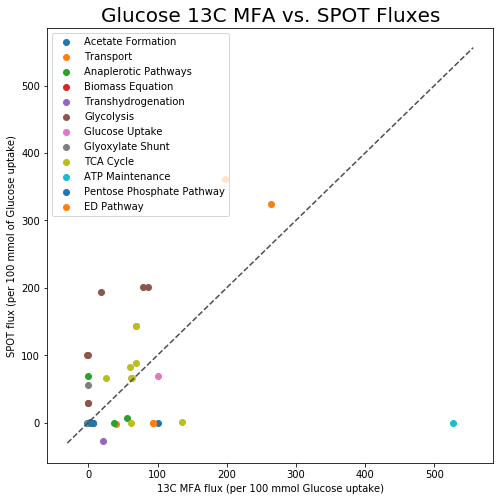

In [105]:
scatterplotcomp_obs_vs_pred(obspred_fluxesnew, substrate='glucose', method='SPOT')

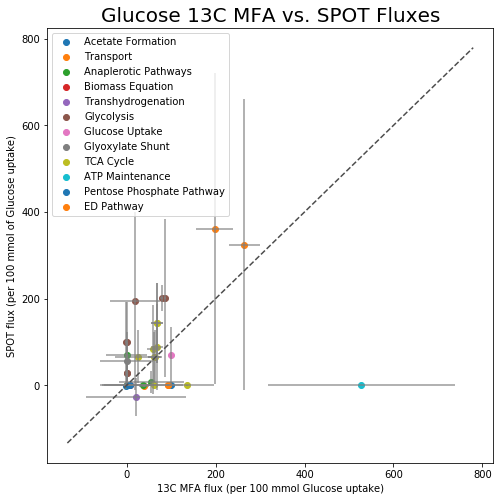

In [106]:
scatterplotcomp_obs_vs_pred_withstd(obspred_fluxesnew, substrate='glucose', method='SPOT')

### Run glucose flux FBA

In [107]:
with model:
    model.objective = 'Growth_Glucose'
    mediumphe = model.medium
    
    # This is to prevent medium components other than phenol from being growth limitations
    mediumphe = {key:1000 for (key,value) in model.medium.items()}
    
    #mediumphe["EX_glc__D_e"] = 0.0
    mediumphe["EX_phenol_e"] = 0.0#100.0
    
    model.medium = mediumphe
#     print(model.medium)
    solutionphe = model.optimize()
    
print(solutionphe)

<Solution 21.681 at 0x7fc0a594c890>


### Add Glucose FBA flux values to test_df 

In [108]:
# fbasoldf = pd.DataFrame(solutionphe, columns=['fluxes'])

In [109]:
# obspred_fluxesnew = addpredfluxes_to13cdf(obspred_fluxes, solutionphe, None, 'phenol', 'FBA')

In [110]:
FBA_fluxes_phe = []
for _, row in glucose_fluxes.iterrows():
    reactions = row['Forward Reactions']
    flux_value_phe = 0
    for x in [x.strip('() ') for x in reactions.split(' or ')]:
        and_split = [y.strip('() ') for y in x.split(' and ')]
        flux_value_phe += min([get_flux_value(v, solutionphe) for v in and_split])
    FBA_fluxes_phe.append(flux_value_phe)
    
glucose_fluxes['FBA Value'] = FBA_fluxes_phe
glucose_fluxes

,Pathway,Forward Reactions,Reaction,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 Value,EFLUX2 std Value,SPOT Value,SPOT std Value,FBA Value
0,Glucose Uptake,GLCpts,Gluc.ext + ATP -> G6P,100.00,100.00,100.00,66.666667,4.336979e+01,68.890717,34.565809,0.000000
1,Glycolysis,PGI,G6P <-> F6P,-1.61,-2.09,1.42,98.410410,6.432021e+01,100.221760,48.335140,366.097358
2,Glycolysis,F6PA and DHAK,F6P + ATP -> FBP,0.00,0.00,1.91,25.686590,1.817473e+01,28.902219,16.594894,0.000000
3,Glycolysis,F6PA and DHAK,FBP <-> DHAP + GAP,0.00,0.00,1.91,25.686590,1.817473e+01,28.902219,16.594894,0.000000
4,Glycolysis,TPI,DHAP <-> GAP,0.00,0.00,1.91,87.076833,5.909743e+01,100.851780,47.787692,323.580954
5,Glycolysis,GAPD and reverse_PGK,GAP <-> 3PG + ATP + NADH,86.56,82.61,88.84,176.766511,-1.193962e+02,201.773310,-95.494005,656.963645
6,Glycolysis,( reverse_PGM or PGM_1 ) and ENO,3PG <-> PEP,78.52,71.65,81.26,169.334371,-1.350031e-13,201.803022,-15.530988,656.963645
7,Glycolysis,FRUpts2pp or reverse_PPS or SBTpts or MNLpts o...,PEP <-> Pyr + ATP,19.02,-10.89,75.15,163.434935,1.126928e+02,194.491261,108.116717,596.727332
8,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,100.00,96.96,100.00,0.000000,0.000000e+00,-0.078956,0.000004,0.000000
9,Pentose Phosphate Pathway,GND,6PG <-> Ru5P + CO2 + NADPH,6.62,2.07,10.92,0.000000,0.000000e+00,-0.015741,0.000001,0.000000


### Plot FBA vs 13C MFA

!!!To Do: Change functions to integrate no std situation!!!

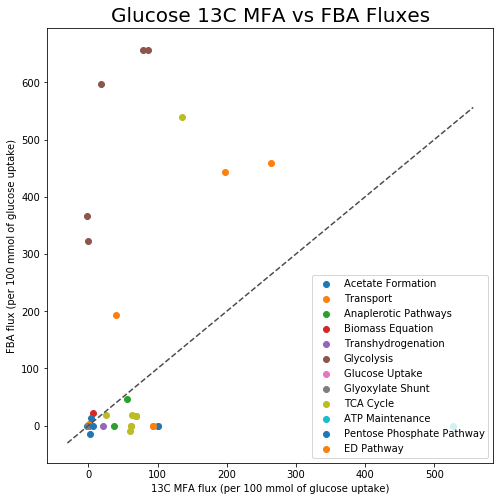

In [111]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

for pathway in list(set(glucose_fluxes['Pathway'])):
    pathway_df = glucose_fluxes[glucose_fluxes['Pathway'] == pathway]
    
    measured_flux_list = list(pathway_df['Flux'])
    simulated_flux_list = list(pathway_df['FBA Value'])
    
    ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)


# Dashed line
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls="--", c=".3")

plt.title(r'Glucose 13C MFA vs FBA Fluxes', fontSize=20)
plt.xlabel(r'13C MFA flux (per 100 mmol of glucose uptake)')
plt.ylabel(r'FBA flux (per 100 mmol of glucose uptake)')
plt.legend()
plt.show()